# Google Drive Mounting 

In [36]:
from google.colab import drive

In [37]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Load x_features and y_features



In [38]:
import pickle
#x_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_Covid_Normal/x_features.pkl','rb'))
#y_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_Covid_Normal/y_features.pkl','rb'))
#x_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_500/x_features.pkl','rb'))
#y_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_500/y_features.pkl','rb'))
x_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_3Classes/x_features.pkl','rb'))
y_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project_3Classes/y_features.pkl','rb'))

In [39]:
import pickle
#x_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project/x_features_resized.pkl','rb'))
#y_features = pickle.load(open('/content/drive/MyDrive/Capstone_Project/y_features_resized.pkl','rb'))

In [40]:
len_classes = 3

'other_pathology'

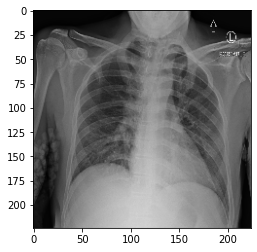

In [41]:
import matplotlib.pyplot as plt
plt.imshow(x_features[1])
y_features[1]

In [42]:
x_features[0].shape,y_features[0]

((224, 224, 3), 'other_pathology')

In [43]:
import tensorflow 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ytrain = le.fit_transform(y_features)
y_train_data = tensorflow.keras.utils.to_categorical(ytrain, len_classes)
y_train_data.shape,y_train_data[0]

((2571, 3), array([0., 0., 1.], dtype=float32))

In [44]:
y_train_data[0]

array([0., 0., 1.], dtype=float32)

In [45]:
ytrain

array([2, 2, 2, ..., 2, 2, 2])

# Normalize the training data and convert into 4 dimensions so that it can be used as an input to conv layers in the model

In [46]:
import numpy  
xtrain_arr = numpy.array(x_features) 
xtrain_arr.shape,xtrain_arr[0].shape

((2571, 224, 224, 3), (224, 224, 3))

In [47]:
x_train_data = xtrain_arr.astype('float32')

#Normalizing the input
x_train_data /= 255.0
print('x_train_data shape:', x_train_data.shape)
print(x_train_data.shape[0], 'train samples')

x_train_data shape: (2571, 224, 224, 3)
2571 train samples


In [48]:
y_train_data.shape

(2571, 3)

## Split the data into training and validation data from `x_train_data` and `y_train_data` obtained from above steps

In [49]:
from sklearn.model_selection import train_test_split
x_train_test, x_val, y_train_test, y_val = train_test_split(x_train_data, y_train_data, test_size=0.20, random_state=1,stratify=y_train_data,shuffle=True)

In [50]:
x_train, x_test, y_train, y_test = train_test_split(x_train_test, y_train_test, test_size=0.10, random_state=1,stratify=y_train_test,shuffle=True)

In [51]:
x_train.shape,y_train.shape,x_val.shape,y_val.shape

((1850, 224, 224, 3), (1850, 3), (515, 224, 224, 3), (515, 3))

In [52]:
import pandas as pd
pd.DataFrame(y_train).value_counts()

0    1    2  
0.0  0.0  1.0    725
     1.0  0.0    720
1.0  0.0  0.0    405
dtype: int64

In [53]:
import pandas as pd
pd.DataFrame(y_val).value_counts()

0    1    2  
0.0  0.0  1.0    202
     1.0  0.0    200
1.0  0.0  0.0    113
dtype: int64

In [54]:
import pandas as pd
pd.DataFrame(y_test).value_counts()

0    1    2  
0.0  0.0  1.0    81
     1.0  0.0    80
1.0  0.0  0.0    45
dtype: int64

# Model Building

### Transfer Learning

Download the vgg wieght file from here : https://github.com/MinerKasch/applied_deep_learning/blob/master/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [80]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [81]:
img_in = Input(x_train.shape[1:])              #input of model 
model = DenseNet121(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight 
                input_tensor= img_in, 
                input_shape= x_train.shape[1:],
                pooling ='avg') 

x = model.output  
predictions = Dense(len_classes, activation="sigmoid", name="predictions")(x)    # fuly connected layer for predict class 
model = Model(inputs=img_in, outputs=predictions)

In [82]:
optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics='accuracy')

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [59]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

In [60]:
#Training on the dataset
model_history = model.fit(x_train, y_train,
          batch_size=32,
          epochs=80,
          verbose=1,
          validation_data=(x_val, y_val),callbacks=[earlyStopping, mcp_save, reduce_lr_loss])

Epoch 1/80
58/58 [==============================] - 36s 431ms/step - loss: 1.0980 - accuracy: 0.5195 - val_loss: 15.7509 - val_accuracy: 0.3864
Epoch 2/80
58/58 [==============================] - 22s 372ms/step - loss: 0.6400 - accuracy: 0.6678 - val_loss: 3.6221 - val_accuracy: 0.3942
Epoch 3/80
58/58 [==============================] - 22s 377ms/step - loss: 0.5396 - accuracy: 0.7412 - val_loss: 4.9795 - val_accuracy: 0.3903
Epoch 4/80
58/58 [==============================] - 22s 373ms/step - loss: 0.4539 - accuracy: 0.7989 - val_loss: 4.7643 - val_accuracy: 0.3942
Epoch 5/80
58/58 [==============================] - 21s 371ms/step - loss: 0.4752 - accuracy: 0.7923 - val_loss: 1.4267 - val_accuracy: 0.5107
Epoch 6/80
58/58 [==============================] - 22s 373ms/step - loss: 0.3403 - accuracy: 0.8569 - val_loss: 2.2052 - val_accuracy: 0.4835
Epoch 7/80
58/58 [==============================] - 22s 374ms/step - loss: 0.3372 - accuracy: 0.8508 - val_loss: 1.2071 - val_accuracy: 0.617

In [77]:
from sklearn import metrics
import numpy as np
predictions = model.predict(x_train)
y_train_pred = []
y_train_act = []
for val in predictions:
    y_train_pred.append(np.argmax(val))

for val1 in y_train:
    y_train_act.append(np.argmax(val1))

cr=metrics.classification_report(y_train_act,y_train_pred)
cm=metrics.confusion_matrix(y_train_act,y_train_pred)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       725

    accuracy                           1.00      1850
   macro avg       1.00      1.00      1.00      1850
weighted avg       1.00      1.00      1.00      1850

[[405   0   0]
 [  0 720   0]
 [  0   0 725]]


In [78]:
from sklearn import metrics
predictions = model.predict(x_val)
y_val_pred = []
y_val_act = []
for val in predictions:
    y_val_pred.append(np.argmax(val))

for val1 in y_val:
    y_val_act.append(np.argmax(val1))

cr=metrics.classification_report(y_val_act,y_val_pred)
cm=metrics.confusion_matrix(y_val_act,y_val_pred)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       113
           1       0.72      0.69      0.71       200
           2       0.70      0.73      0.71       202

    accuracy                           0.76       515
   macro avg       0.79      0.78      0.79       515
weighted avg       0.76      0.76      0.76       515

[[104   5   4]
 [  1 139  60]
 [  4  50 148]]


In [79]:
from sklearn import metrics
predictions = model.predict(x_test)
y_test_pred = []
y_test_act = []
for val in predictions:
  y_test_pred.append(np.argmax(val))

for val1 in y_test:
  y_test_act.append(np.argmax(val1))

cr=metrics.classification_report(y_test_act,y_test_pred)
cm=metrics.confusion_matrix(y_test_act,y_test_pred)
print(cr)
print(cm)

              precision    recall  f1-score   support

           0       0.98      0.91      0.94        45
           1       0.67      0.70      0.69        80
           2       0.69      0.69      0.69        81

    accuracy                           0.74       206
   macro avg       0.78      0.77      0.77       206
weighted avg       0.75      0.74      0.74       206

[[41  3  1]
 [ 0 56 24]
 [ 1 24 56]]


In [64]:
x_val.shape

(515, 224, 224, 3)

In [65]:
from sklearn.metrics import roc_auc_score
aurocs = []
y_pred = model.predict(x_val)
for i in range(len_classes):
  try:
    score = roc_auc_score(y_val[:, i], y_pred[:, i])
    aurocs.append(score)
  except ValueError:
    score = 0

In [66]:
aurocs

[0.9966098709989875, 0.8513492063492063, 0.8318255148198526]

In [67]:
import numpy as np
mean_auroc = np.mean(aurocs)

In [68]:
mean_auroc

0.8932615307226821

In [69]:
scores_train = model.evaluate(x_train, y_train, verbose=2)
print("Accuracy on Train Data: %.2f%%" % (scores_train[1]*100))

58/58 - 5s - loss: 5.2486e-04 - accuracy: 1.0000
Accuracy on Train Data: 100.00%


In [70]:
scores_val = model.evaluate(x_val, y_val, verbose=2)
print("Accuracy on Val Data: %.2f%%" % (scores_val[1]*100))

17/17 - 2s - loss: 0.8208 - accuracy: 0.7592
Accuracy on Val Data: 75.92%


In [71]:
scores_test = model.evaluate(x_test, y_test, verbose=2)
print("Accuracy on Test Data: %.2f%%" % (scores_test[1]*100))

7/7 - 1s - loss: 0.8578 - accuracy: 0.7427
Accuracy on Test Data: 74.27%


In [72]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('final_model.h5')

In [73]:
from tqdm import tqdm
import numpy as np
import cv2

def predict_image(id):
  x_test = []
  y_test = []

  img=cv2.imread('/content/drive/MyDrive/Capstone_Project_3Classes/data/{}'.format(id),1)
  img_resize=cv2.resize(img,(224,224))
  x_test.append(img_resize)
  #y_test.append(lab)
  xtest_arr = numpy.array(x_test) 
  x_test_data = xtest_arr.astype('float32')
  x_test_data /= 255.0
  predictions = model.predict(x_test_data)

  print((np.argmax(predictions)))
  print('Predicted image is', le.inverse_transform([(np.argmax(predictions))])[0])
  #return le.inverse_transform([(np.argmax(predictions))])[0]

In [74]:
predict_image('00000285_002.png')  # Normal 
predict_image('00000324_002.png')  # Normal 
predict_image('covid-19-pneumonia-58-day-3.jpg')  # Covid19
predict_image('covid-19-pneumonia-progression-and-regression-day24.jpg')  # Covid19
predict_image('yxppt-2020-02-19_00-51-27_287214-day8.jpg')  # Covid19
predict_image('00000468_048.png')  # Normal 

1
Predicted image is No Finding
1
Predicted image is No Finding
0
Predicted image is Covid19
0
Predicted image is Covid19
0
Predicted image is Covid19
1
Predicted image is No Finding


In [75]:
from tqdm import tqdm
import numpy as np
import cv2

def predict_image_v(id):
  x_test = []
  y_test = []

  img=cv2.imread('/content/{}'.format(id),1)
  img_resize=cv2.resize(img,(224,224))
  x_test.append(img_resize)
  #y_test.append(lab)
  xtest_arr = numpy.array(x_test) 
  x_test_data = xtest_arr.astype('float32')
  x_test_data /= 255.0
  predictions = model.predict(x_test_data)

  print((np.argmax(predictions)))
  print('Predicted image is', le.inverse_transform([(np.argmax(predictions))])[0])
  #return le.inverse_transform([(np.argmax(predictions))])[0]

In [76]:
predict_image_v('Pneumonia_00000061_015.png')

error: ignored

In [ ]:
predict_image_v('Hernia_00017755_002.png')

In [ ]:
predict_image_v('normal.jpg')

In [ ]:
import matplotlib.pyplot as plt
#Evaluating Accuracy and Loss of the model
%matplotlib inline
acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
loss=model_history.history['loss']
val_loss=model_history.history['val_loss']

epochs=range(len(acc)) #No. of epochs

#Plot training and validation accuracy per epoch
plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'g',label='Testing Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'g',label='Testing Loss')
plt.legend()
plt.show()